In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# extracting data and doing the fit on velocity

In [2]:
from ANEMO.edfreader import read_edf

import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier:
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier:
    file_exp = pickle.load(fichier, encoding='latin1')

datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

In [3]:
def fct_position(x, data_x, saccades, nb_sacc,
             bino, start_anti, v_anti, latence, tau, maxi, px_per_deg,
             t_0, avant=5, apres=10, do_whitening=True):
    
    ms = 1000
    v_anti = (v_anti/ms)
    maxi = maxi /ms

    speed = ANEMO.fct_velocity(x=x, bino=bino, start_anti=start_anti, v_anti=v_anti, latence=latence,
                               tau=tau, maxi=maxi)
    pos = np.cumsum(speed)

    i=0
    for s in range(nb_sacc) :
        sacc = saccades[i:i+3] # obligation d'avoir les variable indé a la même taille :/
                                # saccades[i] -> debut, saccades[i+1] -> fin, saccades[i+2] -> tps sacc
        if sacc[0]-t_0 < len(x) :
            if sacc[0]-t_0 > int(latence) :
                if int(sacc[1]-t_0)+apres <= len(pos) :
                    pos[int(sacc[0]-t_0)-avant:int(sacc[1]-t_0)+apres] = pos[int(sacc[0]-t_0)-avant-1] # np.nan 
                    pos[int(sacc[1]-t_0)+apres:] += ((data_x[int(sacc[1]-t_0)+apres]-data_x[int(sacc[0]-t_0)-avant-1])/px_per_deg) - np.mean(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]

                else :
                    pos[int(sacc[0]-t_0)-avant:] = pos[int(sacc[0]-t_0)-avant-1] # np.nan
        i = i+3
    
    if do_whitening is True:
        pos = whitening(pos)
    
    return pos

# doing the fit

In [4]:
def Fit_position(data_trial, trackertime, bino, fct_fit='fct_velocity', data_x=None, px_per_deg=None,
              param_fit=None, TargetOn=None, StimulusOf=None, saccades=None, sup=True, time_sup=-280,
              do_whitening=True, avant=5, apres=10, step=2) :


    from lmfit import  Model, Parameters

    t_0 = trackertime[0]

    if param_fit is None :
        param_fit={'tau':[15.,13.,80.], 'maxi':[15.,1.,40], 'v_anti':[0.,-40.,40.],
                   'latence':[TargetOn-t_0+100,TargetOn-t_0+75,'STOP'],
                   'start_anti':[TargetOn-t_0-100, StimulusOf-t_0-200, TargetOn-t_0+75]}

    if param_fit['latence'][2]=='STOP' :
        stop_latence = []
        for s in range(len(saccades)) :
            if (saccades[s][0]-t_0) >= (TargetOn-t_0+100) :
                stop_latence.append((saccades[s][0]-t_0))
        if stop_latence==[] :
            stop_latence.append(len(trackertime))
        stop = stop_latence[0]
    else :
        stop = param_fit['latence'][2]


    if sup==True :
        data_trial = data_trial[:time_sup]
        trackertime = trackertime[:time_sup]
        if fct_fit == 'fct_position' :
            data_x = data_x[:time_sup]
     
    if do_whitening:
        
        data_trial = whitening(data_trial)
        data_x = whitening(data_x)

    params = Parameters()

    if fct_fit == 'fct_velocity' :
        model = Model(ANEMO.fct_velocity)
    elif fct_fit == 'fct_position' :
        model = Model(fct_position, independent_vars=['x', 'data_x', 'saccades', 'do_whitening'])
        params.add('t_0', value=t_0, vary=False)
        params.add('avant', value=avant, vary=False)
        params.add('apres', value=apres, vary=False)
        params.add('px_per_deg', value=px_per_deg, vary=False)


        params.add('nb_sacc', value=len(saccades), vary=False)

        sacc = np.zeros(len(trackertime))
        i=0
        for s in range(len(saccades)):
            
            sacc[i] = saccades[s][0] # debut sacc
            sacc[i+1] = saccades[s][1] # fin sacc
            sacc[i+2] = saccades[s][2] # tps sacc
            i = i+3

    if step == 1 :
        vary = True
    elif step == 2 :
        vary = False

    params.add('maxi', value=param_fit['maxi'][0], min=param_fit['maxi'][1], max=param_fit['maxi'][2])
    params.add('latence', value=param_fit['latence'][0], min=param_fit['latence'][1], max=stop)

    params.add('bino', value=bino, vary=False)

    params.add('tau', value=param_fit['tau'][0], min=param_fit['tau'][1], max=param_fit['tau'][2], vary=vary)
    params.add('start_anti', value=param_fit['start_anti'][0], min=param_fit['start_anti'][1], max=param_fit['start_anti'][2], vary=vary)
    params.add('v_anti', value=param_fit['v_anti'][0], min=param_fit['v_anti'][1], max=param_fit['v_anti'][2], vary=vary)

    if step == 1 :
        if fct_fit=='fct_velocity' :
            result_deg = model.fit(data_trial, params, x=np.arange(len(trackertime)), nan_policy='omit')
        elif fct_fit=='fct_position' :
            result_deg = model.fit(data_trial, params, x=np.arange(len(trackertime)), data_x=data_x,
                                   saccades=sacc, do_whitening=do_whitening, nan_policy='omit')


    elif step == 2 :
        if fct_fit=='fct_velocity' :
            out = model.fit(data_trial, params, x=np.arange(len(trackertime)), nan_policy='omit')
        elif fct_fit=='fct_position' :
            #print('3',sacc, np.arange(len(trackertime)), data_x, data_trial)
            out = model.fit(data_trial, params, x=np.arange(len(trackertime)), data_x=data_x,
                            saccades=sacc, do_whitening=do_whitening, nan_policy='omit')

        # make the other parameters vary now
        out.params['tau'].set(vary=True)
        out.params['start_anti'].set(vary=True)
        out.params['v_anti'].set(vary=True)

        if fct_fit=='fct_velocity' :
            result_deg = model.fit(data_trial, out.params,
                                x=np.arange(len(trackertime)),
                                method='nelder', nan_policy='omit')
                                #fit_kws=dict(maxiter=maxiter))
            # par défaut dans scipy.optimize.minimize(method=’Nelder-Mead’) maxiter=N*200 (N nb de variable)
        elif fct_fit=='fct_position' :
            result_deg = model.fit(data_trial, out.params, x=np.arange(len(trackertime)), data_x=data_x,
                                   saccades=sacc, do_whitening=do_whitening, method='nelder', nan_policy='omit')

    return result_deg


# whitening

In [5]:
N_freq = 1301
    
def whitening_filt(N_freq, white_f_0, white_alpha, white_steepness):
    """
    Returns the envelope of the whitening filter.

        then we return a 1/f spectrum based on the assumption that the structure of signals
        is self-similar and thus that the Fourier spectrum scales a priori in 1/f.

    """
    freq = np.fft.fftfreq(N_freq, d=1.)
    K = np.abs(freq)**(white_alpha)
    K *= np.exp(-(np.abs(freq)/white_f_0)**white_steepness)
    K /= np.mean(K)

    return freq, K

def whitening(position, white_f_0=.4, white_alpha=1., white_steepness=4):
    """
    Returns the whitened image
    """
    try :
        N_freq = position.shape[0]
    except AttributeError :
        N_freq = len(position)
    freq, K = whitening_filt(N_freq=N_freq, white_f_0=white_f_0, white_alpha=white_alpha, white_steepness=white_steepness)        
    f_position = np.fft.fft(position)
    
    return np.real(np.fft.ifft(f_position*K))

# Fonction

In [6]:
from ANEMO import ANEMO

In [7]:
block = 0
num1, num2 = 0, 200

fi_true = {'start_anti' : [], 'v_anti' : [], 'latence' : [], 'tau' : [], 'maxi' : []}
fi_false = {'start_anti' : [], 'v_anti' : [], 'latence' : [], 'tau' : [], 'maxi' : []}

for trial in np.arange(num1,num2) :
    
    print(trial)
    arg = ANEMO.arg(data, file_exp, trial, block)
    trial_data = trial + arg.N_trials*block
    time, t_0 = arg.trackertime, arg.
    start, start1 = arg.TargetOn, arg.TargetOn-t_0
    data_x = arg.data_x - (arg.data_x[arg.StimulusOf-t_0])
    
    debut, fin = 0, 15
    kwarg = {'data_x':data_x, 'trackertime': arg.trackertime, 'bino': arg.bino, 'TargetOn': arg.TargetOn,
             'StimulusOf': arg.StimulusOf, 'saccades': arg.saccades, 'px_per_deg':arg.px_per_deg,
             'param_fit': None,  'avant': debut, 'apres': fin, 'fct_fit':'fct_position',
             'sup': True, 'time_sup': -280, 'step': 2}
    

    sacc = np.zeros(len(arg.trackertime))
    i=0
    for s in range(len(arg.saccades)):
        sacc[i] = arg.saccades[s][0] # debut sacc
        sacc[i+1] = arg.saccades[s][1] # fin sacc
        sacc[i+2] = arg.saccades[s][2] # tps sacc
        i = i+3
    
    for do_whitening in [True, False] :
        
        #print(do_whitening)
        if do_whitening==True :
            fi = fi_true
        else :
            fi = fi_false
            
        popo = fct_position(range(len(arg.trackertime)), data_x, sacc, int(len(arg.saccades)), arg.bino,
                    param['start_anti'][block][trial]+start1, param['v_anti'][block][trial],
                    param['latence'][block][trial]+start1, param['tau'][block][trial],
                    param['maxi'][block][trial], arg.px_per_deg, t_0, debut, fin,
                    do_whitening)
        c = Fit_position(popo, do_whitening=do_whitening, **kwarg)


        fi['start_anti'].append(c.values['start_anti']-start1)
        fi['v_anti'].append(c.values['v_anti'])
        fi['latence'].append(c.values['latence']-start1)
        fi['tau'].append(c.values['tau'])
        fi['maxi'].append(c.values['maxi'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


# Comparaison

In [10]:
def regress(ax, p, data, minx, miny, maxx, maxy, t_label=12) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c='r', linewidth=2)
    ax.text(maxx-((maxx-minx)/16.180),miny+((maxy-miny)/10), 'r = %0.3f'%(r_), color='r', fontsize=t_label/1.2, ha='right')

    return ax

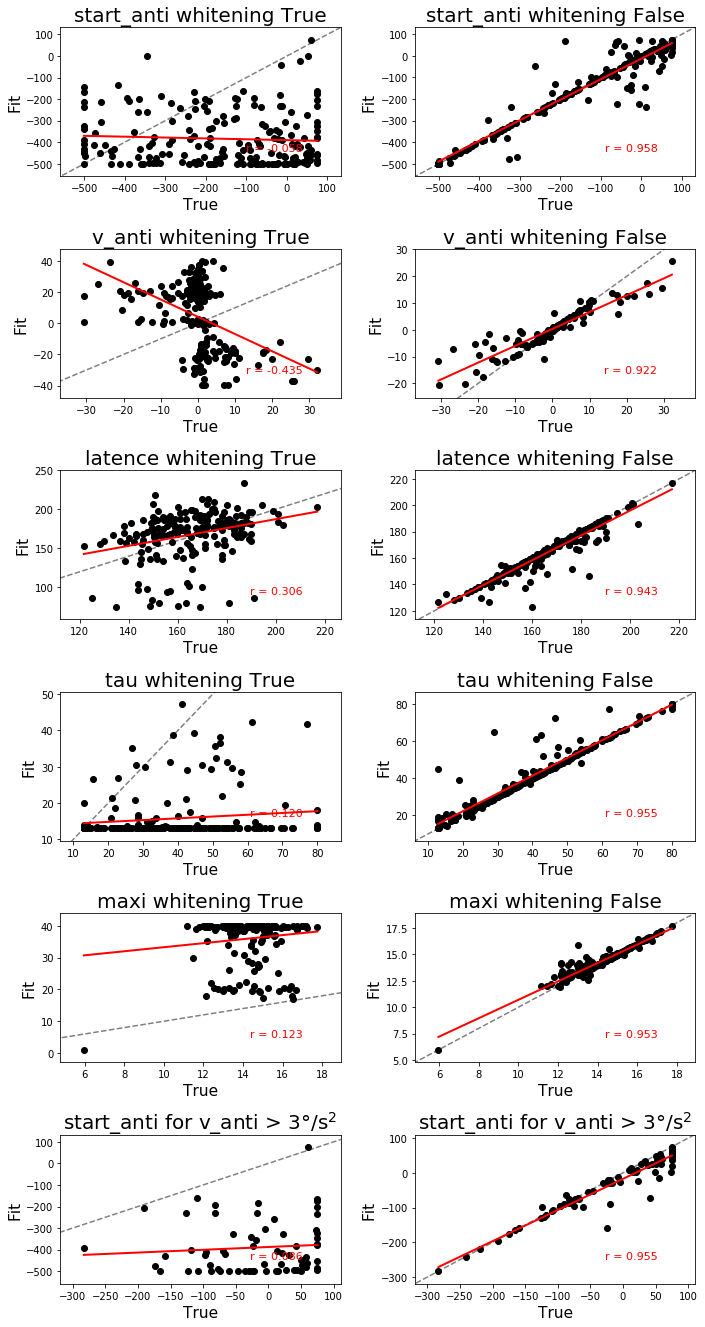

In [13]:
fig_width= 5
fig, axs = plt.subplots(6, 2, figsize=(2*fig_width, 6*(fig_width)/1.6180))

t_titre = 20

liste = ['start_anti', 'v_anti', 'latence', 'tau', 'maxi']
fifi = [fi_true, fi_false]

ploup = ['whitening True', 'whitening False'] 

for b, fi in enumerate(fifi) :

    for a, lala in enumerate(liste) :
        axs[a][b].set_title('%s %s'%(lala, ploup[b]), fontsize=t_titre)
        axs[a][b].set_xlabel('True', fontsize=t_titre/1.3)
        axs[a][b].set_ylabel('Fit', fontsize=t_titre/1.3)

        axs[a][b].plot([-2000, 2000], [-2000, 2000], '--k', alpha=0.5)

        axs[a][b].scatter(param['%s'%lala][block][num1:num2], fi['%s'%lala], c='k')

        min_x, min_y = min(param['%s'%lala][block][num1:num2]), min(fi['%s'%lala])
        max_x, max_y = max(param['%s'%lala][block][num1:num2]), max(fi['%s'%lala])
        axs[a][b] = regress(axs[a][b], param['%s'%lala][block][num1:num2], fi['%s'%lala], min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
        axs[a][b].axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10), min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)]) 


    seuil = 3
    new_start_anti_fit = []
    new_start_anti_true = []
    for s in range(num2-num1) :
        if abs(param['v_anti'][block][s]) > seuil :
            if abs(fi['v_anti'][s]) > seuil :
                new_start_anti_fit.append(fi['start_anti'][s])
                new_start_anti_true.append(param['start_anti'][block][s])

    axs[5][b].set_title('start_anti for v_anti > 3°/s$^2$', fontsize=t_titre)
    axs[5][b].set_xlabel('True', fontsize=t_titre/1.3)
    axs[5][b].set_ylabel('Fit', fontsize=t_titre/1.3)

    axs[5][b].plot([-2000, 2000], [-2000, 2000], '--k', alpha=0.5)

    axs[5][b].scatter(new_start_anti_true, new_start_anti_fit, c='k')

    min_x, min_y = min(new_start_anti_true), min(new_start_anti_fit)
    max_x, max_y = max(new_start_anti_true), max(new_start_anti_fit)
    axs[5][b] = regress(axs[5][b], new_start_anti_true, new_start_anti_fit, min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
    axs[5][b].axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10), min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)]) 

plt.tight_layout();